In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import h5py
import gzip
import json
import os
import tqdm

import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
raw_graph = pd.read_csv('data/travel_graph_country_level.tsv', delimiter='\t')

In [16]:
raw_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8563 entries, 0 to 8562
Data columns (total 3 columns):
country_i              8563 non-null object
country_j              8563 non-null object
avg_daily_travelers    8563 non-null float64
dtypes: float64(1), object(2)
memory usage: 200.8+ KB


In [17]:
8563*2

17126

In [3]:
import json
countries_metadata = json.load(open('data/countries_metadata.json'))

## Country ISO3 to code mapping

In [4]:
countries_iso_to_id_map = dict([(value['country_iso3'], int(key)) for key, value in countries_metadata.items()])

In [5]:
with gzip.open('data/output_0000.h5.gz') as fp:
    f = h5py.File(fp,'r')
    compartments = f['dset'].attrs['Columns']
    country_ids = f['dset'].attrs['SelectedCountries']
    prevalence = np.array(f['dset/countries/cumulative'], dtype=np.int64)
    incidence = np.array(f['dset/countries/transitions'], dtype=np.int64)

In [6]:
country_id_to_idx_map = dict((cid, ix) for ix, cid in enumerate(country_ids))
country_id_to_idx_map

{71: 0,
 140: 1,
 149: 2,
 222: 3,
 103: 4,
 183: 5,
 199: 6,
 53: 7,
 113: 8,
 29: 9,
 221: 10,
 207: 11,
 47: 12,
 28: 13,
 213: 14,
 76: 15,
 157: 16,
 109: 17,
 181: 18,
 154: 19,
 164: 20,
 178: 21,
 50: 22,
 79: 23,
 108: 24,
 185: 25,
 7: 26,
 31: 27,
 128: 28,
 91: 29,
 75: 30,
 227: 31,
 70: 32,
 80: 33,
 81: 34,
 12: 35,
 179: 36,
 176: 37,
 172: 38,
 210: 39,
 94: 40,
 67: 41,
 200: 42,
 129: 43,
 218: 44,
 215: 45,
 110: 46,
 188: 47,
 2: 48,
 82: 49,
 187: 50,
 150: 51,
 61: 52,
 177: 53,
 119: 54,
 16: 55,
 180: 56,
 95: 57,
 208: 58,
 147: 59,
 54: 60,
 86: 61,
 15: 62,
 88: 63,
 60: 64,
 90: 65,
 158: 66,
 230: 67,
 58: 68,
 8: 69,
 144: 70,
 89: 71,
 202: 72,
 130: 73,
 104: 74,
 138: 75,
 10: 76,
 13: 77,
 161: 78,
 35: 79,
 193: 80,
 111: 81,
 229: 82,
 72: 83,
 48: 84,
 153: 85,
 5: 86,
 84: 87,
 117: 88,
 22: 89,
 191: 90,
 112: 91,
 73: 92,
 120: 93,
 214: 94,
 107: 95,
 62: 96,
 116: 97,
 85: 98,
 0: 99,
 206: 100,
 115: 101,
 34: 102,
 25: 103,
 45: 104,
 160: 1

## Construct graph

In [7]:
def construct_adj_matrix(raw_graph, countries_iso_to_id_map):
    """
    raw_graph: list of edges and edge value
    """
    n_countries = len(countries_iso_to_id_map)
    adj_mx = np.zeros((n_countries, n_countries), dtype=np.float)
    for idx, row in raw_graph.iterrows():
        loc_a, loc_b = (
            # get the correct ordering according to the indices in the construction
            country_id_to_idx_map[countries_iso_to_id_map[row["country_i"]]],
            country_id_to_idx_map[countries_iso_to_id_map[row["country_j"]]],
        )
        adj_mx[loc_a, loc_b] = row["avg_daily_travelers"]
        adj_mx[loc_b, loc_a] = row["avg_daily_travelers"]
    return adj_mx

In [8]:
adj_mx = construct_adj_matrix(raw_graph, countries_iso_to_id_map)

In [9]:
# Sanity check
(adj_mx.T == adj_mx).all()

True

In [22]:
import torch
a = torch.Tensor([[2, 3, 4], [2, 3, 4], [2, 3, 6]])
print(a.shape)
torch.split(a, (1, 2), dim=0)

torch.Size([3, 3])


(tensor([[2., 3., 4.]]), tensor([[2., 3., 4.],
         [2., 3., 6.]]))

## Visualize

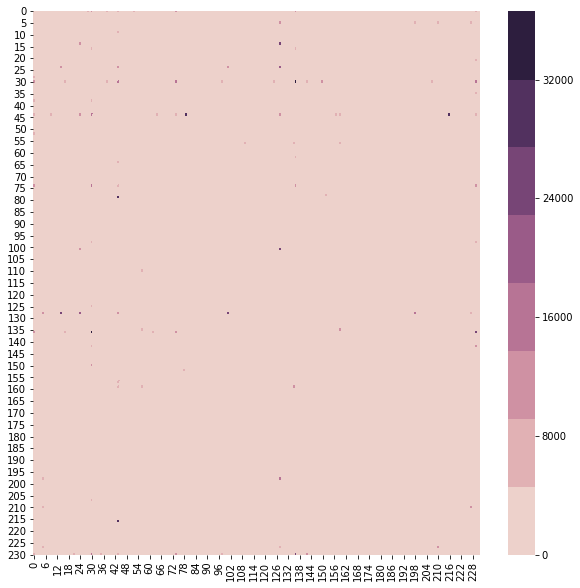

In [38]:
import seaborn as sns
plt.figure(figsize=(10, 10))
# sns.heatmap((adj_mx - adj_mx.mean(axis=1))/adj_mx.std(axis=1), cmap=sns.cubehelix_palette(8))
sns.heatmap((adj_mx), cmap=sns.cubehelix_palette(8))

## Construct threshold gaussian kernel according to DCRNN

References:
1. http://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf

In [20]:
def get_threshold_gaussian_kernel(adj_mx, normalized_k=0.1):
    flat = adj_mx[~np.isinf(adj_mx)].flatten()
    std = flat.std()
    adj_mx = np.exp(-np.square(adj_mx / std))
    # Make the adjacent matrix symmetric by taking the max.
    # adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])

    # Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
    adj_mx[adj_mx < normalized_k] = 0
    return adj_mx

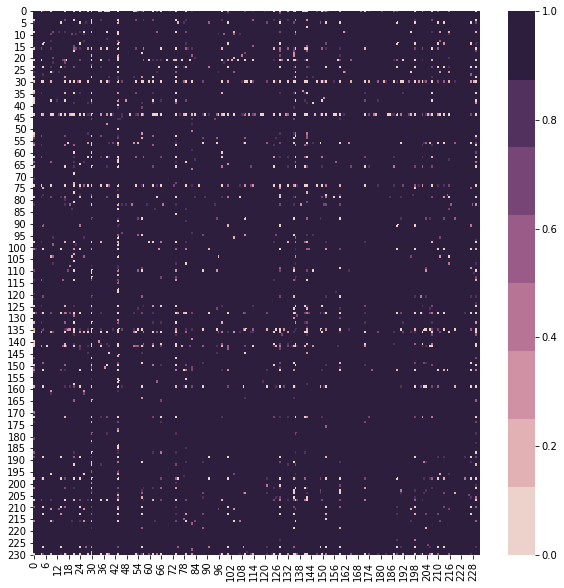

In [21]:
adj_mx = get_threshold_gaussian_kernel(adj_mx)
import seaborn as sns
plt.figure(figsize=(10, 10))
# sns.heatmap((adj_mx - adj_mx.mean(axis=1))/adj_mx.std(axis=1), cmap=sns.cubehelix_palette(8))
sns.heatmap((adj_mx), cmap=sns.cubehelix_palette(8))

## Save Adj Mx

In [39]:
np.save('data/EpiGCN/adj_mx', adj_mx)

## NetworkX Graph creation

In [48]:
import networkx as nx

G = nx.from_numpy_array(adj_mx, create_using=nx.Graph)

In [53]:
nx.is_frozen(G)

False

## Implement graph clustering

The approach we can try is to use HCS Clustering algorithm based on min-cut algorithm to find sets of highly connected subgraphs

see: https://en.wikipedia.org/wiki/HCS_clustering_algorithm

reference implementation: https://github.com/53RT/Highly-Connected-Subgraphs-Clustering-HCS/blob/master/hcs.py

In [93]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c).copy()

class HCSClustering:
    def is_highly_connected(self, graph, min_cut_edges):
        return len(min_cut_edges) > (len(graph) / 2.0)
    
    def disconnect_components(self, graph, min_cut_edges):
        for edge in min_cut_edges:
            graph.remove_edge(*edge)
        return graph
    
    def hcs(self, graph):
        min_cut_edges = nx.minimum_edge_cut(graph)
        if len(graph) > 2 and not self.is_highly_connected(graph, min_cut_edges):
            graph = self.disconnect_components(graph, min_cut_edges)
            disconnected_components = list(connected_component_subgraphs(graph))
            if len(disconnected_components) > 2:
                raise Exception("more than 2 components")
            c1, c2 = self.hcs(disconnected_components[0]), self.hcs(disconnected_components[1])
            graph = nx.compose(c1, c2)
        return graph

In [111]:
clustered_graph = HCSClustering().hcs(G.copy())

In [114]:
nx.connected_components(clustered_graph)

<generator object connected_components at 0x7fe3de26cdd0>

In [117]:
nx.write_gpickle(clustered_graph, 'data/EpiGCN/hcs_components.gpkl')